941
Number of qubits in circuit 32
Circuit depth: 32


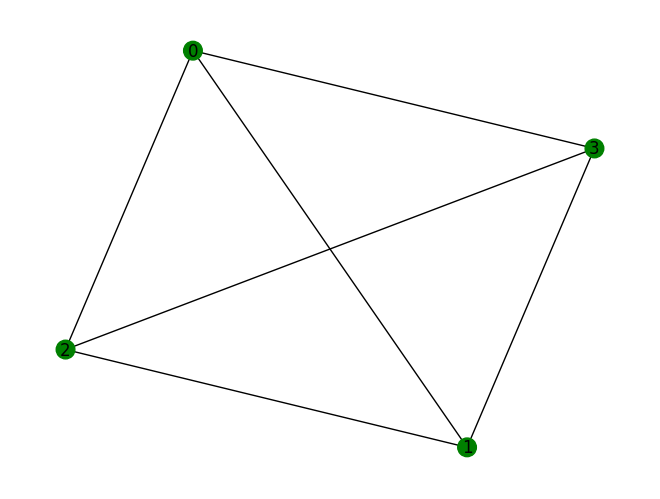

In [1]:
from qiskit.circuit.library import QFT, QuantumVolume
from disqco.circuits.cp_fraction import cp_fraction, cz_fraction
from qiskit import transpile, QuantumCircuit
from QASMBench.interface.qiskit import QASMBenchmark
from disqco.graphs.quantum_network import QuantumNetwork, linear_coupling, grid_coupling, all_to_all, tree_network
from disqco.graphs.QC_hypergraph import QuantumCircuitHyperGraph
import numpy as np
%load_ext jupyter_tikz

num_qubits = 32

seed = np.random.randint(0, 1000)

print(seed)

circuit = cp_fraction(num_qubits, num_qubits, fraction=0.5, seed=8360)

# circuit = QuantumCircuit(num_qubits)
# for i in range(num_qubits-3):
#     circuit.cp(0.5, 0, (i + 1))

# circuit.cp(0.5, 0, num_qubits-1)
 

# circuit = QFT(num_qubits, do_swaps=False)
# 
# circuit = QuantumVolume(num_qubits, depth=num_qubits)
# Transpile the circuit to the basis gates
basis_gates = ['u', 'cp'] 
circuit = transpile(circuit, basis_gates=basis_gates)

num_partitions = 4  # Define the number of partitions or QPUs you will distribute over
depth = circuit.depth()

qpu_size = num_qubits // num_partitions + 1  # Define the number of qubits per QPU. For simplicity, we divide qubits evenly and add one additional space to each for teleportation (an extra space is needed for the teleportation qubit so the algorithmr requires it!)
qpu_sizes = [qpu_size] * num_partitions # Store the number of qubits per QPU in a list

# Create a quantum network with the specified number of qubits and partitions

# If we do not specificy the connectivity, we have all-to-all by default.
# coupling = grid_coupling(num_partitions)
# coupling = linear_coupling(num_partitions)  # Linear coupling for a linear topology
coupling = all_to_all(num_partitions)  # Fully connected network

# coupling = [(0,1),(1,2),(2,3),(2,4)]
quantum_network = QuantumNetwork(qpu_sizes, qpu_connectivity=coupling)

# graph = QuantumCircuitHyperGraph(circuit, group_gates=False)


# fig = graph.draw(show_labels=False)
# display(fig)

graph = QuantumCircuitHyperGraph(circuit, group_gates=True)

print(f'Number of qubits in circuit {circuit.num_qubits}')
print(f'Circuit depth: {circuit.depth()}')

from disqco.parti.FM.fiduccia import *

FM_partitioner = FiducciaMattheyses(circuit=circuit,
                                    hypergraph=graph,
                                    network=quantum_network,
                                    graph=graph,
                                    initial_assignment=set_initial_partition_assignment(graph, quantum_network),
                                    )
quantum_network.draw()



# circuit.draw(output='mpl', style='bw', cregbundle=True, fold=50)

In [2]:
from disqco.graphs.coarsening.coarsener import HypergraphCoarsener

coarsener = HypergraphCoarsener()

coarseneing_method = coarsener.coarsen_recursive_batches_mapped

# results = FM_partitioner.multilevel_partition()

results = FM_partitioner.net_coarsened_partition()

NameError: name 'set_initial_partition_assignment' is not defined

In [ ]:
print(f'Best cost: {results['best_cost']}')

# graph.draw(network=quantum_network,
#            assignment=results['best_assignment'],dpi=600)

Best cost: 98


In [ ]:
from disqco.circuit_extraction.circuit_extractor import PartitionedCircuitExtractor

extractor = PartitionedCircuitExtractor(graph=graph, 
                                        network=quantum_network, 
                                        partition_assignment=results['best_assignment'])

extracted_circuit = extractor.extract_partitioned_circuit()

Processing group gate {'type': 'group', 'root': 22, 'time': 0, 'sub-gates': [{'type': 'two-qubit', 'name': 'cp', 'qargs': [22, 7], 'qregs': ['q', 'q'], 'params': [0.5141756164480557], 'time': 0}, {'type': 'two-qubit', 'name': 'cp', 'qargs': [22, 7], 'qregs': ['q', 'q'], 'params': [4.160939054853807], 'time': 1}]} at time 0 for root qubit 22
Final time step for group gates [{'type': 'two-qubit', 'name': 'cp', 'qargs': [22, 7], 'qregs': ['q', 'q'], 'params': [0.5141756164480557], 'time': 0}, {'type': 'two-qubit', 'name': 'cp', 'qargs': [22, 7], 'qregs': ['q', 'q'], 'params': [4.160939054853807], 'time': 1}]: 1
Root qubit physical index: Qubit(QuantumRegister(9, 'Q0_q'), 6)
Linked qubits for root 22: {0: Qubit(QuantumRegister(9, 'Q0_q'), 6)}
Processing group gate {'type': 'group', 'root': 28, 'time': 0, 'sub-gates': [{'type': 'two-qubit', 'name': 'cp', 'qargs': [28, 10], 'qregs': ['q', 'q'], 'params': [1.160318066020432], 'time': 0}, {'type': 'two-qubit', 'name': 'cp', 'qargs': [28, 15], 

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# STILL NEED TO CONFIRM THIS IS WORKING - WHY DOES COST DECREASE BY 6 JUST FROM CLEANING SINGLE QUBIT GATES FROM THE END OF GROUPS?


extracted_circuit = transpile(extracted_circuit, basis_gates=basis_gates + ['cx'] + ['x'] + ['z'] + ['EPR'])

print(f' Number of EPR pairs in circuit: {extracted_circuit.count_ops().get("EPR", 0)}')

extracted_circuit.remove_final_measurements()

# final_circuit.draw(style='bw',output='mpl', cregbundle=True, fold=50)

 Number of EPR pairs in circuit: 98


In [ ]:
from disqco.circuit_extraction.verification import check_no_cross_partition_gates

is_valid = check_no_cross_partition_gates(extracted_circuit, quantum_network.qpu_graph)
print("Circuit valid:", is_valid)

Circuit valid: True


In [ ]:
# extracted_circuit.draw(style='bw', output='mpl', cregbundle=True, fold=50)